<a href="https://colab.research.google.com/github/husanaulakh/ENPH353_Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import math
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, backend
from keras.utils import plot_model
from ipywidgets import interact
import ipywidgets as ipywidgets
from sklearn.metrics import confusion_matrix

In [2]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

In [3]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 60.6MB/s]


In [4]:
path = "/content/"

NUMBER_OF_PLATES = 10

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [6]:
dir_path = "/content/pictures/"
images = []

for filename in os.listdir(dir_path):
  if filename.endswith(".png"):
    images.append(cv2.imread(os.path.join(dir_path, filename)))

sub_imgs = []
labels = []

for image, filename in zip(images, os.listdir(dir_path)):
    letters = filename.split("_")[1].split(".")[0]
    sub_img1 = image[100:220,50:150]
    sub_img2 = image[100:220,150:250]
    sub_img3 = image[100:220,345:445]
    sub_img4 = image[100:220,445:545]
    sub_imgs.extend([sub_img1, sub_img2, sub_img3, sub_img4])
    labels.extend(list(letters))

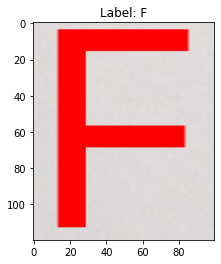

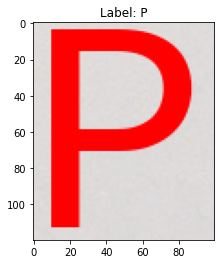

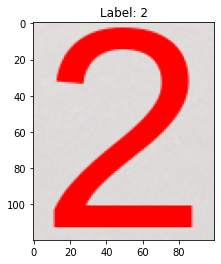

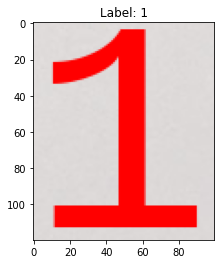

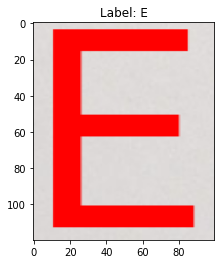

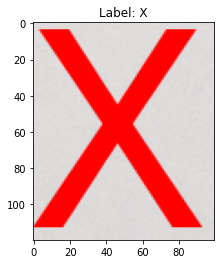

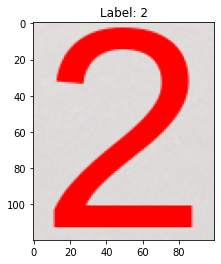

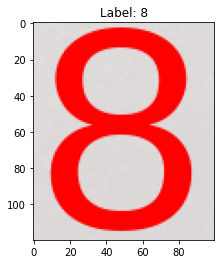

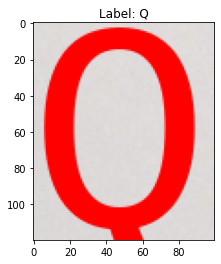

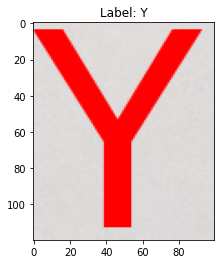

In [7]:
for i in range(10):
    plt.imshow(sub_imgs[i])
    plt.title("Label: " + labels[i])
    plt.show()

In [8]:
# Define a string that contains all the letters and digits
characters = string.ascii_uppercase + string.digits

# Define a dictionary that maps each character to its one-hot vector representation
char_to_vec = {char: [int(char == c) for c in characters] for char in characters}

# Convert each label to its one-hot vector representation
one_hot_labels = [char_to_vec[str(label)] for label in labels]

In [9]:
X_dataset = np.array(sub_imgs)
Y_dataset = np.array(one_hot_labels)

In [10]:
VALIDATION_SPLIT = 0.2

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (40, 120, 100, 3)
Y shape: (40, 36)
Total examples: 40
Training examples: 32
Validation examples: 8


# Train CNN
Function for reinitializing the model parameters

In [11]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [12]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(36))



# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(120, 100, 3)))


# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(120, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(120, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(512, activation='relu'))
# conv_model.add(layers.Dense(36, activation='softmax'))




# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 100, 3)))
# conv_model.add(layers.MaxPooling2D((2,2)))
# conv_model.add(layers.MaxPooling2D((2,2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(512, activation='relu'))
# conv_model.add(layers.Dense(36, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 98, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 47, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 171456)            0         
                                                                 
 dense (Dense)               (None, 36)                6172452   
                                                                 
Total params: 6,191,844
Trainable params: 6,191,844
Non-trainable params: 0
______________________________________________

In [14]:
# LEARNING_RATE = 1e-4
# model.compile(loss='categorical_crossentropy',
#                    optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
#                    metrics=['acc'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
reset_weights(model)
history_conv = model.fit(X_train_dataset, Y_train_dataset, validation_data=(X_val_dataset, Y_val_dataset), epochs=20)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 73.7329 - accuracy: 0.0625 - val_loss: 1432.3304 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 831ms/step - loss: 666.5221 - accuracy: 0.8125 - val_loss: 2267.9329 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 834ms/step - loss: 1134.1162 - accuracy: 0.0312 - val_loss: 1876.1943 - val_accuracy: 0.3750
Epoch 4/20
1/1 [==============================] - 1s 591ms/step - loss: 752.1666 - accuracy: 0.7188 - val_loss: 1479.9287 - val_accuracy: 0.3750
Epoch 5/20
1/1 [==============================] - 0s 460ms/step - loss: 538.3533 - accuracy: 0.5000 - val_loss: 1068.2303 - val_accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 491ms/step - loss: 332.0226 - accuracy: 0.6562 - val_loss: 624.2795 - val_accuracy: 0.3750
Epoch 7/20
1/1 [==============================] - 1s 533ms/step - loss: 125.6806 - accuracy: 0.7188 - val_loss: 360.1596 - val_acc

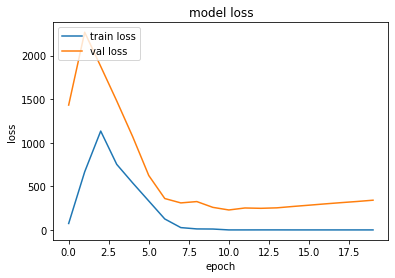

In [20]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

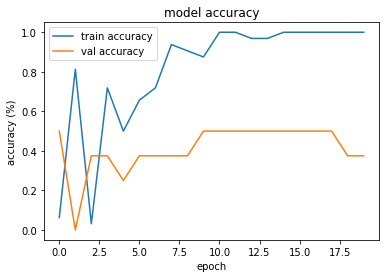

In [17]:
plt.plot(history_conv.history['accuracy'])
plt.plot(history_conv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()